In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import tkinter
import matplotlib
import collections
import json
import itertools
import random
from collections import defaultdict

In [2]:
G = nx.read_edgelist("edges.csv", delimiter=',')

In [3]:
def show_graph(G):
    plt.subplot(121)
    nx.draw_circular(G, with_labels=True, font_weight='bold', node_size=500, font_size=10)
    plt.show()

C:\Users\Pouria\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


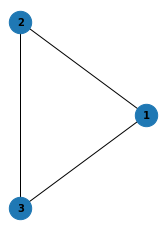

In [9]:
triangle = nx.Graph()
triangle.add_edge(1,2)
triangle.add_edge(2,3)
triangle.add_edge(1,3)
show_graph(triangle)

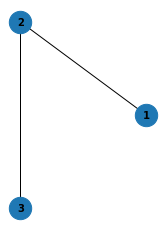

In [10]:
two_star = nx.Graph()
two_star.add_edge(1,2)
two_star.add_edge(2,3)
show_graph(two_star)

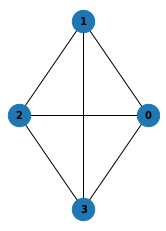

In [11]:
four_clique = nx.complete_graph(4)
show_graph(four_clique)

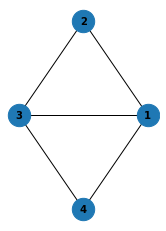

In [12]:
chordal_cycle = nx.Graph()
chordal_cycle.add_edge(1,2)
chordal_cycle.add_edge(1,3)
chordal_cycle.add_edge(1,4)
chordal_cycle.add_edge(2,3)
chordal_cycle.add_edge(3,4)
show_graph(chordal_cycle)

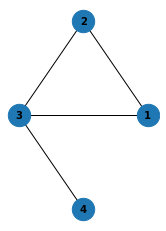

In [13]:
tailed_triangle = nx.Graph()
tailed_triangle.add_edge(1,2)
tailed_triangle.add_edge(1,3)
tailed_triangle.add_edge(2,3)
tailed_triangle.add_edge(3,4)
show_graph(tailed_triangle)

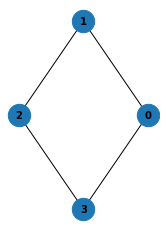

In [14]:
four_cycle = nx.cycle_graph(4)
show_graph(four_cycle)

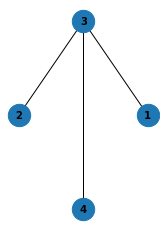

In [15]:
three_star = nx.Graph()
three_star.add_edge(1,3)
three_star.add_edge(2,3)
three_star.add_edge(3,4)
show_graph(three_star)

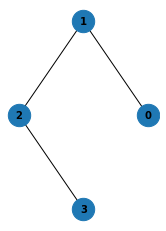

In [16]:
four_path = nx.path_graph(4)
show_graph(four_path)

In [ ]:
def graphlets_nodes(G, target):
    result = []
    for sub_nodes in itertools.combinations(G.nodes(),len(target.nodes())):
        #subg = G.subgraph(sub_nodes)
        subg = subgraph(G, sub_nodes)
        if nx.is_connected(subg) and nx.is_isomorphic(subg, target):
            result.append(subg.edges())
    return result

In [5]:
def create_graph_neighbors(G, selected_edges):
    nodes = []
    for i in selected_edges:
        nodes = nodes + [j for j in G.neighbors(i[0])]
        nodes = nodes + [j for j in G.neighbors(i[1])]
    nodes = list(set(nodes))
    graph = G.subgraph(nodes)
    return graph

In [6]:
def graphlets_edges(G, target, sampling_factor):
    G_ = G
    selected_edges = random.sample(list(G_.edges()),round(sampling_factor*G_.number_of_edges() ))
    G_ = create_graph_neighbors(G, selected_edges)
    visited = []
    count = 0
    print("Total number of edges: %d"%len(selected_edges))
    for index, edges in enumerate(selected_edges):
        neighbors = []
        neighbors = neighbors + [i for i in G_.neighbors(edges[0])]
        neighbors = neighbors + [i for i in G_.neighbors(edges[1])]
        if target.number_of_nodes() == 3:
            for i in neighbors:
                if i != edges[0] or i != edges[1]:
                    nodes = [edges[0], edges[1], i]
                    G_sub = G_.subgraph(nodes)
                    if sorted(list(G_sub.nodes())) not in visited:
                        if nx.is_connected(G_sub) and nx.is_isomorphic(G_sub, target):
                            visited.append(sorted(list(G_sub.nodes())))
                            count += 1
        elif target.number_of_nodes() == 4:
            for i in neighbors:
                for j in neighbors:
                    if i!=j:
                        nodes = [edges[0], edges[1], i, j]
                        G_sub = G_.subgraph(nodes)
                        #G_sub = subgraph(G_, nodes)
                        if sorted(list(G_sub.nodes())) not in visited:
                            if nx.is_connected(G_sub) and nx.is_isomorphic(G_sub, target):
                                visited.append(sorted(list(G_sub.nodes())))
                                count += 1
        if index%1==0:
            print("%d "%index, end='')
    #print(count)
    if sampling_factor != 1:
        if sampling_factor <= 0.1:
            count *= 0.4
        elif 0.1<sampling_factor <= 0.5:
            count *= 0.5 #Normalization
        elif 0.5 < sampling_factor:
            count *= 0.8 #Normalization
    return float(count)/sampling_factor

In [18]:
def estimate_evaluation(G, size, target):

    offset = random.randint(0, G.number_of_edges())
    small_G = G.edge_subgraph(list(G.edges())[offset:offset+size])
    #small_G = G
    #print("Calculating exact number for %d nodes (sampling factor = 1)"%small_G.number_of_nodes())
    exact = int(graphlets_edges(small_G, target, sampling_factor=1))
    graphlet_estimate_pd = pd.DataFrame(columns=["Sampling Factor", "Estimated", "Relative Error"])
    sampling_factor_list = [0.05, 0.1, 0.25, 0.5, 0.75]
    for i, v in enumerate(sampling_factor_list):
        print("-"*20)
        print("Sampling Factor: %f"%v)
        estimated = 0
        for j in range(1):
            estimated += graphlets_edges(small_G, target, sampling_factor=v)
        estimated /= 1
        estimated = int(round(estimated))
        if exact==0:
            relative_error = abs(exact - estimated)
        else:
            relative_error = abs(exact - estimated)/exact
        graphlet_estimate_pd.loc[i] = (v, estimated, relative_error) 
    graphlet_estimate_pd.loc[len(sampling_factor_list)] = (1, exact, 0)
    return graphlet_estimate_pd

In [ ]:
graphlet_estimate_pd = estimate_evaluation(G, 3000, triangle)
print("\nEstimation for 3000 edges. Triangle")
graphlet_estimate_pd


Estimation for 3000 edges. Triangle


,Sampling Factor,Estimated,Relative Error
0,0.05,128.0,0.372549
1,0.10,208.0,0.019608
2,0.25,268.0,0.313725
3,0.50,185.0,0.093137
4,0.75,214.0,0.049020
5,1.00,204.0,0.000000


In [ ]:
graphlet_estimate_pd = estimate_evaluation(G, 3000, two_star)
print("Estimation for 3000 edges. Two Star")
graphlet_estimate_pd

Estimation for 3000 edges. Two Star


,Sampling Factor,Estimated,Relative Error
0,0.05,46704.0,0.147675
1,0.10,38124.0,0.304256
2,0.25,47348.0,0.135922
3,0.50,40709.0,0.257081
4,0.75,54841.0,0.000821
5,1.00,54796.0,0.000000


In [ ]:
graphlet_estimate_pd = estimate_evaluation(G, 600, three_star)
print("Estimation for 600 edges. Four Clique")
graphlet_estimate_pd

600
Total number of edges: 600
0 100 200 300 400 500 --------------------
Sampling Factor: 0.050000
600
Total number of edges: 30
0 --------------------
Sampling Factor: 0.100000
600
Total number of edges: 60
0 --------------------
Sampling Factor: 0.250000
600
Total number of edges: 150
0 100 --------------------
Sampling Factor: 0.500000
600
Total number of edges: 300
0 100 200 --------------------
Sampling Factor: 0.750000
600
Total number of edges: 450
0 100 200 300 400 Estimation for 600 edges. Four Clique


,Sampling Factor,Estimated,Relative Error
0,0.05,23480.0,0.047747
1,0.10,24084.0,0.074699
2,0.25,26262.0,0.171888
3,0.50,19899.0,0.112048
4,0.75,23652.0,0.055422
5,1.00,22410.0,0.000000


In [22]:
def estimate_graphlets(G, target):
    small_G = G
    graphlet_estimate_pd = pd.DataFrame(columns=["Sampling Factor", "Estimated"])
    sampling_factor_list = [0.005]
    for i, v in enumerate(sampling_factor_list):
        print("-"*20)
        print("Sampling Factor: %f"%v)
        estimated = 0
        for j in range(1):
            estimated += graphlets_edges(small_G, target, sampling_factor=v)
        estimated /= 1
        estimated = int(round(estimated))
        graphlet_estimate_pd.loc[i] = (v, estimated) 
    return graphlet_estimate_pd

In [ ]:
graphlet_estimate_pd = estimate_graphlets(G, triangle)
print("\nEstimation for the whole graph. Triangle")
graphlet_estimate_pd

--------------------
Sampling Factor: 0.005000
Total number of edges: 306
0 100 200 300 
Estimation for the whole graph. Triangle


,Sampling Factor,Estimated
0,0.005,36400.0


In [ ]:
graphlet_estimate_pd = estimate_graphlets(G, two_star)
print("\nEstimation for the whole graph. Two Star")
graphlet_estimate_pd

--------------------
Sampling Factor: 0.005000
Total number of edges: 306
0 100 200 300 
Estimation for the whole graph. Two Star


,Sampling Factor,Estimated
0,0.005,1094560.0


In [ ]:
graphlet_estimate_pd = estimate_graphlets(G, four_clique)
print("\nEstimation for the whole graph. Four Clique")
graphlet_estimate_pd

--------------------
Sampling Factor: 0.005000
Total number of edges: 306
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 

,Sampling Factor,Estimated
0,0.005,23600.0


In [ ]:
graphlet_estimate_pd = estimate_graphlets(G, chordal_cycle)
print("\nEstimation for the whole graph. Chordal Cycle")
graphlet_estimate_pd

--------------------
Sampling Factor: 0.005000
Total number of edges: 306
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 

,Sampling Factor,Estimated
0,0.005,220160.0


In [ ]:
graphlet_estimate_pd = estimate_graphlets(G, tailed_triangle)
print("\nEstimation for the whole graph. Tailed Triangle")
graphlet_estimate_pd

--------------------
Sampling Factor: 0.005000
Total number of edges: 306
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 

,Sampling Factor,Estimated
0,0.005,2855760.0


In [16]:
graphlet_estimate_pd = estimate_graphlets(G, four_cycle)
print("\nEstimation for the whole graph. Four Cycle")
graphlet_estimate_pd

--------------------
Sampling Factor: 0.005000
Total number of edges: 306
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 

,Sampling Factor,Estimated
0,0.005,78320.0


In [17]:
graphlet_estimate_pd = estimate_graphlets(G, four_path)
print("\nEstimation for the whole graph. Four Path")
graphlet_estimate_pd

--------------------
Sampling Factor: 0.005000
Total number of edges: 306
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 

,Sampling Factor,Estimated
0,0.005,7543760.0


In [23]:
graphlet_estimate_pd = estimate_graphlets(G, three_star)
print("\nEstimation for the whole graph. Three Star")
graphlet_estimate_pd

--------------------
Sampling Factor: 0.001000
Total number of edges: 61
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 
Estimation for the whole graph. Three Star


,Sampling Factor,Estimated
0,0.001,31786800.0


In [32]:
print("Estimated number of graphlets in the whole graph.")
df = pd.DataFrame(columns=["Sampling Factor", "Estimated"])
df.loc["Triangle"] = [0.005, 36400]
df.loc["Two Star"] = [0.005, 1094560]
df.loc["Four Clique"] = [0.005, 23600]
df.loc["Chordal Cycle"] = [0.005, 220160]
df.loc["Tailed Triangle"] = [0.005, 2855760]
df.loc["Four Cycle"] = [0.005, 78320]
df.loc["Three Star"] = [0.001, 31786800]
df.loc["Four Path"] = [0.005, 7543760]
df

Estimated number of graphlets in the whole graph.


,Sampling Factor,Estimated
Triangle,0.005,36400.0
Two Star,0.005,1094560.0
Four Clique,0.005,23600.0
Chordal Cycle,0.005,220160.0
Tailed Triangle,0.005,2855760.0
Four Cycle,0.005,78320.0
Three Star,0.001,31786800.0
Four Path,0.005,7543760.0
